# Optimal Portfolio
This notebook construct 3 different optimal portfolios. The maximum sharpe-ratio portfolio (*simple risk adjusted return*), the maximum calmar-ratio portfolio (*maximum drawdown adjusted return*) and the minimum variance portfolio.

\begin{align}
    \text{Sharpe Ratio}&=\frac{R_{p}-R_{f}}{\sigma_{p}}\\
    \text{Calmar Ratio}&=\frac{R_{p}-R_{f}}{\text{Maximum Drawdown}}
\end{align}
where $R_{p}$ denotes the portfolio's annualized return, $R_{f}$ denotes the risk-free interest rate, $\sigma_{p}$ denotes the standard deviation ($\approx$*risk*) of the portfolio and maximum drawdown is measured as the pct.-change from trough to peak, i.e. peak-value minus trough-value divided by peak-value.




In [1]:
############## Loading relevant packages ##############
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# local module
import pftools
import VaR_and_ES as vares
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## Loading and cleaning data
In this notebook, data can be fetched using the downloaded CSV-files or using the yahoo database.

In [2]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with yahoo database or file-name
tickers = ['SXR8', 'XACTC25', 'XDJP', 'LCUA' ,'SXRP', 'SXRL', 'XJSE'] # stock and bonds ETFs
# tickers = ['SXR8', 'XACTC25', 'XDJP', 'LCUA'] # only stock ETFs

# getting data from a local csv-file
df, rdf, cdf = pftools.df_generator(tickers,'csv','C:/Users/olufk/OneDrive/Documents/GitHub/PortfolioDesign/PortfolioDesign/OptimalPF/Data_Investing_com/')

First observation in dataframe is         04-01-2010
Note that SXR8       first appears at the 28-05-2010
                     This means theres is missing data from the first 0.4 years, corresponding to approximately 99 trading days/observations

Note that XACTC25    first appears at the 08-02-2019
                     This means theres is missing data from the first 9.09 years, corresponding to approximately 2292 trading days/observations

Note that XDJP       first appears at the 07-03-2013
                     This means theres is missing data from the first 3.17 years, corresponding to approximately 798 trading days/observations

Note that LCUA       first appears at the 11-06-2018
                     This means theres is missing data from the first 8.44 years, corresponding to approximately 2125 trading days/observations

Note that XJSE       first appears at the 03-12-2013
                     This means theres is missing data from the first 3.91 years, corresponding to approxi

In [3]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with yahoo database or file-name
tickers = ['FORTUM.HE', 'WM','AMD', 'ASML.AS', 'FB', 'SE', '600887.SS', 'SHOP', 'ST5.DE','SNPS','TTD','ZS','NEPA.ST','EW','ACN','NESTE.HE']

# enter time period of interest
start = dt.datetime(2014, 6, 30)
end = dt.datetime(2019, 6, 30)

# getting data from yahoo database
df, rdf, cdf = pftools.df_generator(tickers,'yahoo')

No starttime selected, has therefore chosen default closest to (5 years before today) 2016-09-25
No endtime selected, has therefore chosen default which is the latest trading day as of 2021-09-25

First observation in dataframe is         26-09-2016
Note that SE         first appears at the 20-10-2017
                     This means theres is missing data from the first 1.07 years, corresponding to approximately 268 trading days/observations

Note that ZS         first appears at the 16-03-2018
                     This means theres is missing data from the first 1.47 years, corresponding to approximately 369 trading days/observations



## Describing each tickers
Now that data is loaded, it's time to get an idea of the characteristics of the tickers

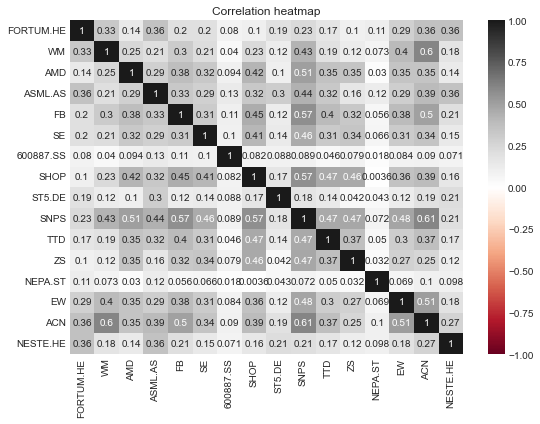

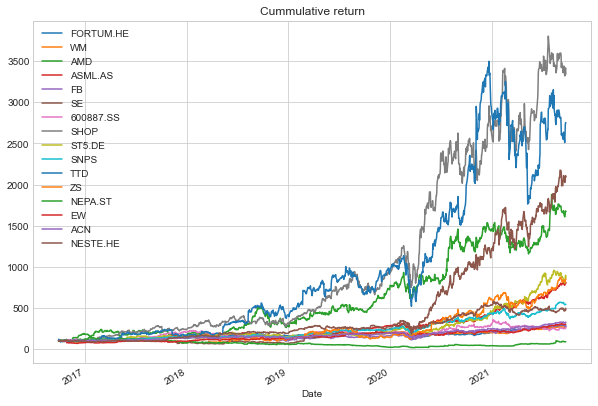

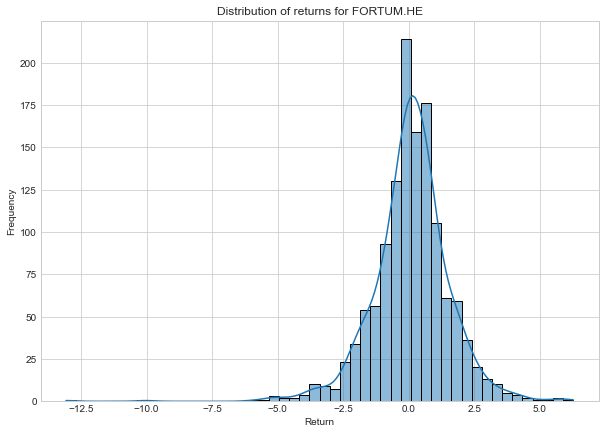

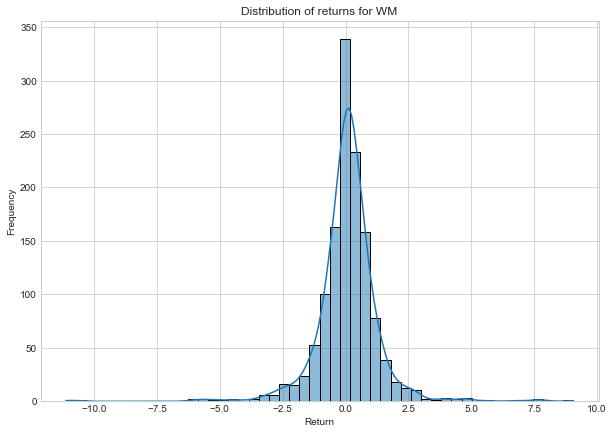

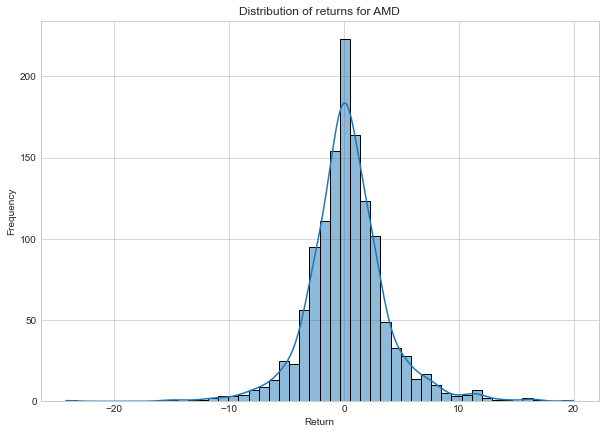

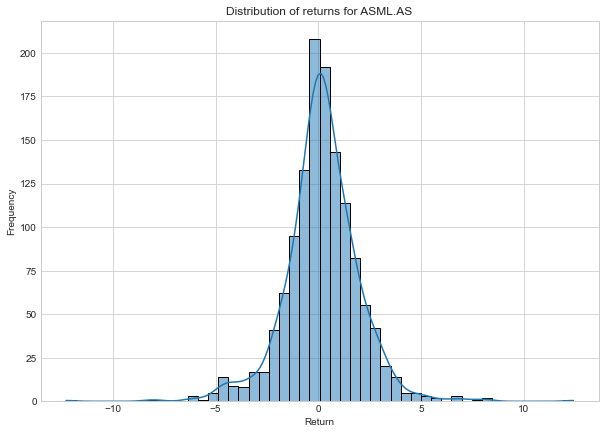

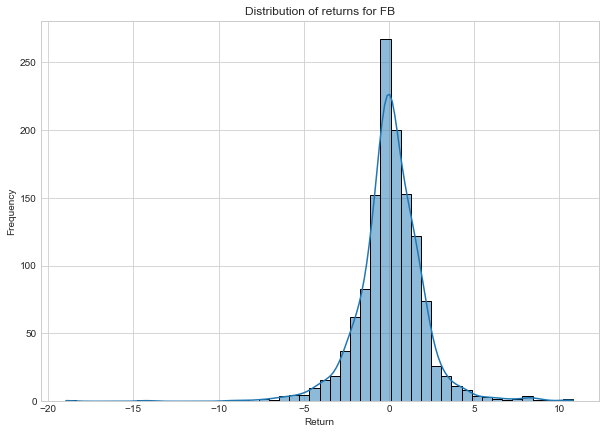

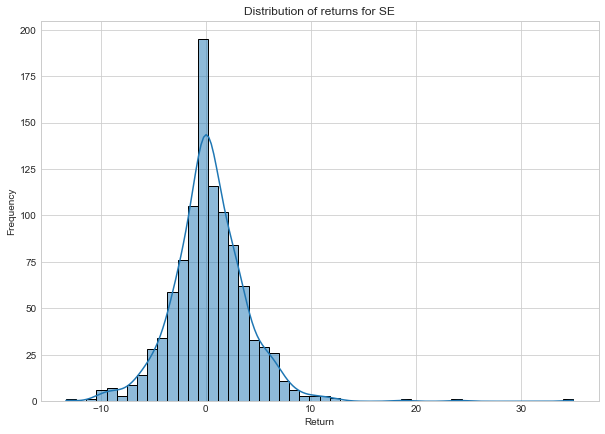

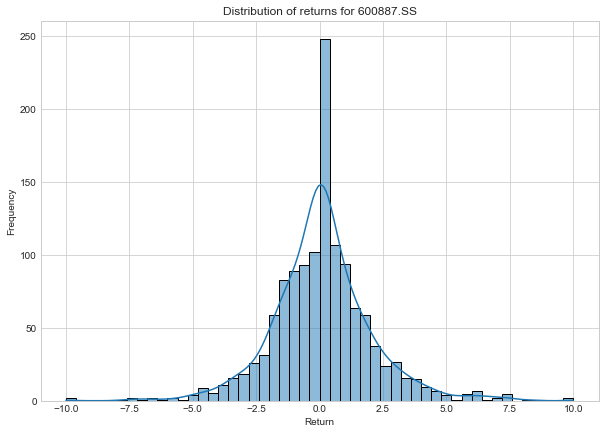

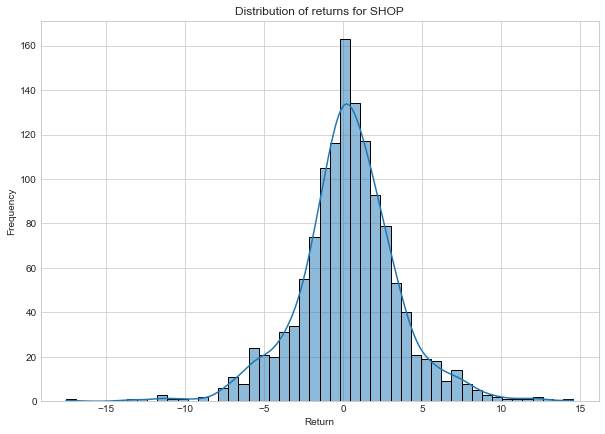

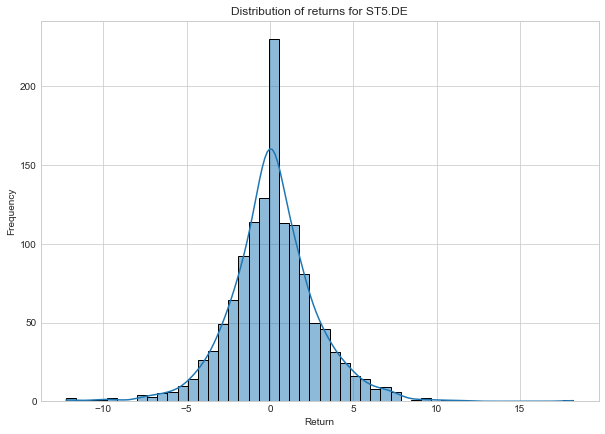

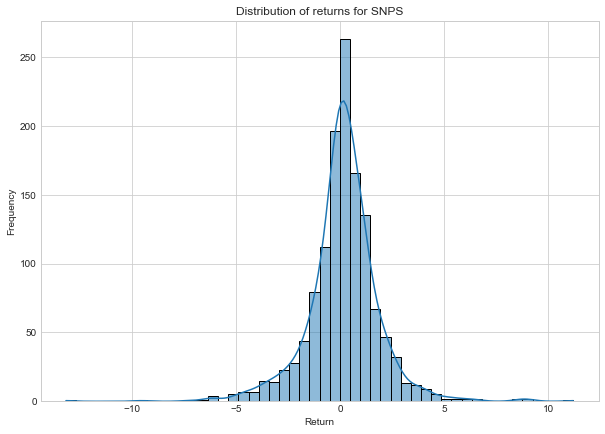

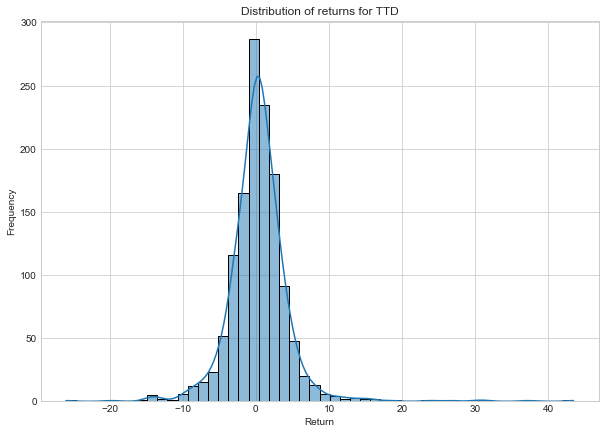

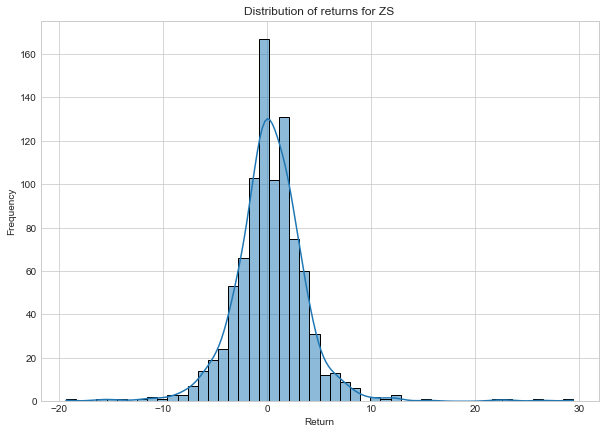

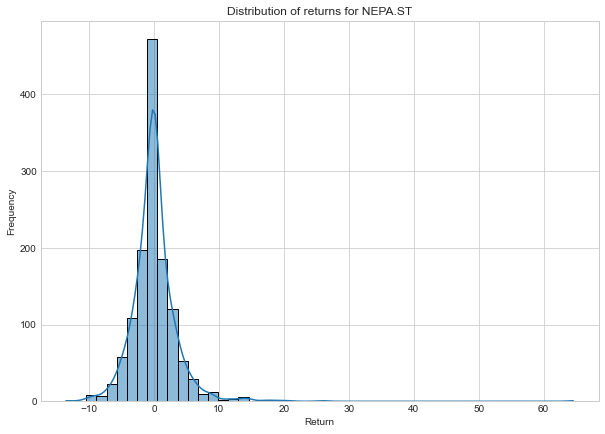

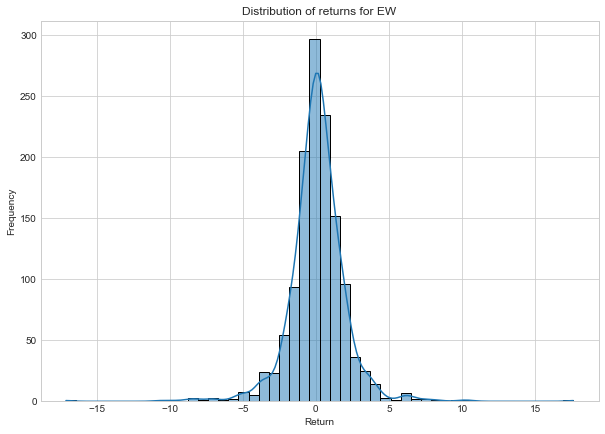

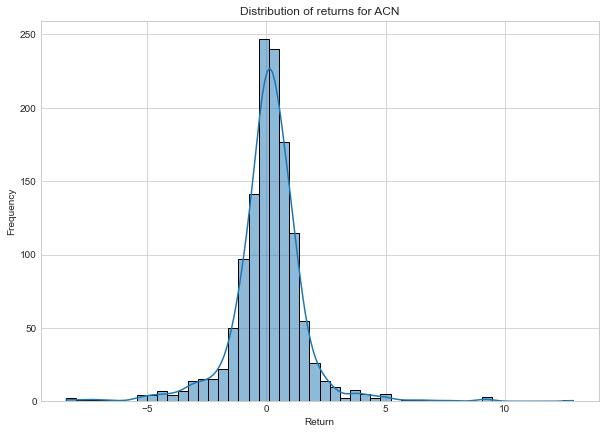

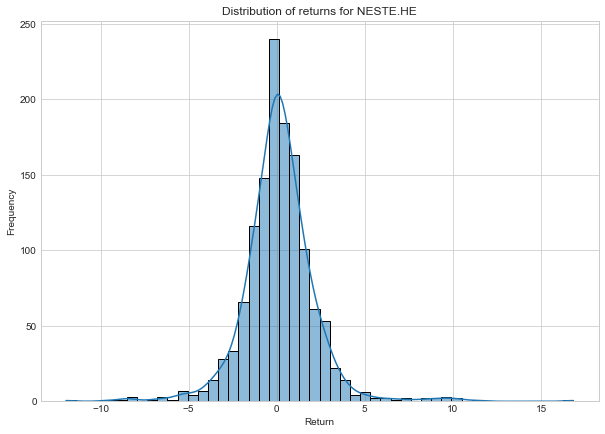

,Annualized return,Volatility,Sharpe ratio,1m max drawdown,Calmar ratio
Ticker,,,,,
FORTUM.HE,22.91,23.59,0.97,40.44,0.57
WM,21.82,20.07,1.09,29.13,0.75
AMD,75.75,55.73,1.36,45.90,1.65
ASML.AS,51.60,28.98,1.78,35.03,1.47
FB,22.64,32.20,0.70,32.53,0.70
SE,116.76,58.08,2.01,27.62,4.23
600887.SS,21.22,32.78,0.65,20.07,1.06
SHOP,101.83,50.50,2.02,39.33,2.59
ST5.DE,53.66,41.95,1.28,48.59,1.10


In [4]:
mu = pftools.desc_ticks(df,rdf,cdf)

In [5]:
omega_hat, alpha_hat, ll = vares.ARCH1_est('WM',df)

Estimating WM as a ARCH(1)-model resulted in:
--------------------------------------------------------------------------------------
Omega^hat                       --> 0.7294 with std. errors (0.0305) and t-val 23.9482
alpha^hat                       --> 0.7258 with std. errors (0.0575) and t-val 12.6223
Maximized log-likelihood        --> -1525.739
--------------------------------------------------------------------------------------


Risk measures for WM at 1 period losses with a 0.05 risk level is
-----------------------------------------
Gauss
-----
VaR                             --> 2.09
ES                              --> 2.61
-----------------------------------------
ARCH(1)
------
VaR (average)                   --> 1.94
ES  (average)                   --> 2.44
-----------------------------------------


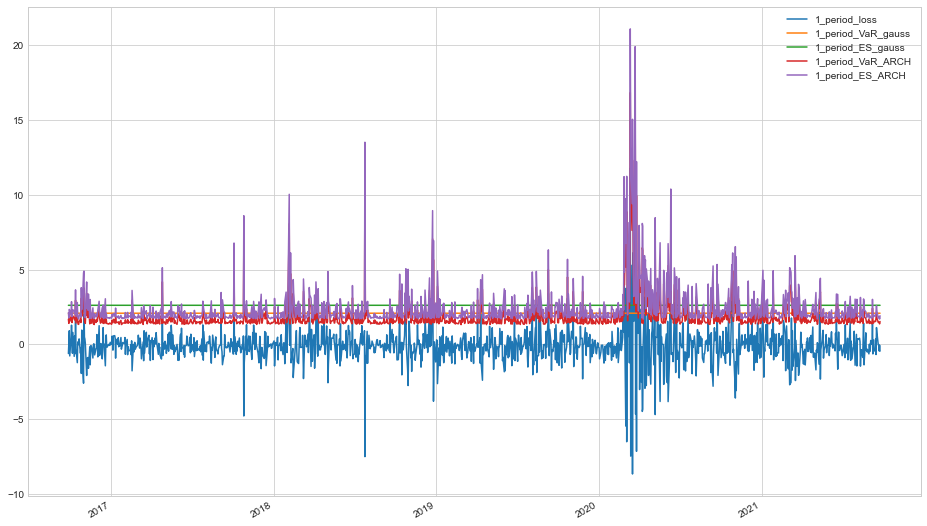

In [6]:
vares_df = vares.VaRES(omega_hat,alpha_hat,df,'WM',0.05,1,2000)
vares_df.plot(figsize = (16,10));

In [7]:
pftools.ana_optimal_portfolios(df,rdf,mu)

-----------------------------------------------------------------------------------------------

The analytical solution for the minimum variance portfolio (allows for shorting) resulted in:



,weight
Ticker,
FORTUM.HE,17.84
WM,38.52
AMD,-2.02
ASML.AS,7.17
FB,5.82
SE,-3.32
600887.SS,16.24
SHOP,-0.12
ST5.DE,4.60


With portfolio characteristics:



,stats
Annualized return,21.85
Volatility,14.78
Sharpe ratio,1.48
1m max drawdown,27.70
Calmar ratio,0.79


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

The analytical solution for the efficient tangent portfolio (allows for shorting) resulted in:



,weight
Ticker,
FORTUM.HE,4.66
WM,41.85
AMD,7.64
ASML.AS,33.39
FB,-24.63
SE,21.79
600887.SS,8.54
SHOP,23.47
ST5.DE,15.02


With portfolio characteristics:



,stats
Annualized return,86.98
Volatility,29.49
Sharpe ratio,2.95
1m max drawdown,35.20
Calmar ratio,2.47


-----------------------------------------------------------------------------------------------

Cannot analytically solve the maximum calmar ratio portfolio


In [8]:
import warnings
warnings.filterwarnings('ignore') # theres a bug in scipy 1.6 which throws runtime warnings at you. This suppress' it
smvw, stw, scw = pftools.num_optimal_portfolios(df,mu,50,True)
warnings.filterwarnings('default')

SHORTING IS ALLOWED
-------------------------------------------------------
Will numerically solve the minimum variance portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 5 times
The improvements of the optimal solution resulted in no notable deviations of allocation.

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,17.84
WM,38.52
AMD,-2.02
ASML.AS,7.17
FB,5.82
SE,-3.32
600887.SS,16.24
SHOP,-0.12
ST5.DE,4.60


With portfolio characteristics:


,stats
Annualized return,21.85
Volatility,14.78
Sharpe ratio,1.48
1m max drawdown,27.70
Calmar ratio,0.79


-------------------------------------------------------
Will numerically solve the efficient tangent portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 1 times
The improvements of the optimal solution resulted in no notable deviations of allocation.

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,4.66
WM,41.84
AMD,7.64
ASML.AS,33.39
FB,-24.63
SE,21.79
600887.SS,8.54
SHOP,23.47
ST5.DE,15.03


With portfolio characteristics:


,stats
Annualized return,86.99
Volatility,29.49
Sharpe ratio,2.95
1m max drawdown,35.20
Calmar ratio,2.47


Currently no numerical solution for maximum calmar ratio portfolio with shorting - will therefore be solved for
SHORTING IS NOT ALLOWED
-------------------------------------------------------
Will numerically solve the calmar portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 2 times
The improvements of the optimal solution resulted in no notable deviations of allocation.

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,0.00
WM,0.00
AMD,0.00
ASML.AS,0.00
FB,0.00
SE,75.58
600887.SS,0.00
SHOP,0.00
ST5.DE,0.00


With portfolio characteristics:


,stats
Annualized return,108.59
Volatility,50.60
Sharpe ratio,2.15
1m max drawdown,24.78
Calmar ratio,4.38


In [9]:
warnings.filterwarnings('ignore')
mvw, tw, cw = pftools.num_optimal_portfolios(df,mu,50,False)
warnings.filterwarnings('default')

SHORTING IS NOT ALLOWED
-------------------------------------------------------
Will numerically solve the minimum variance portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 8 times
The improvements of the optimal solution resulted in no notable deviations of allocation.

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,17.70
WM,38.49
AMD,0.00
ASML.AS,5.66
FB,4.21
SE,0.00
600887.SS,16.51
SHOP,0.00
ST5.DE,4.43


With portfolio characteristics:


,stats
Annualized return,25.81
Volatility,15.00
Sharpe ratio,1.72
1m max drawdown,28.26
Calmar ratio,0.91


-------------------------------------------------------
Will numerically solve the efficient tangent portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 5 times
The improvements of the optimal solution resulted in no notable deviations of allocation.

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,0.55
WM,11.97
AMD,2.20
ASML.AS,20.55
FB,0.00
SE,15.56
600887.SS,6.64
SHOP,15.49
ST5.DE,13.19


With portfolio characteristics:


,stats
Annualized return,65.19
Volatility,23.99
Sharpe ratio,2.72
1m max drawdown,33.87
Calmar ratio,1.92


-------------------------------------------------------
Will numerically solve the calmar portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 3 times
The improvements of the optimal solution resulted in no notable deviations of allocation.

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,0.00
WM,0.00
AMD,0.00
ASML.AS,0.00
FB,0.00
SE,75.58
600887.SS,0.00
SHOP,0.00
ST5.DE,0.00


With portfolio characteristics:


,stats
Annualized return,108.59
Volatility,50.60
Sharpe ratio,2.15
1m max drawdown,24.78
Calmar ratio,4.38


Simulating 1000 timeseries for each type of portfolio where shorting is allowed
--------------------------------------------------------------------------------

Simulates the minimum variance portfolio 1000 times over 63 days


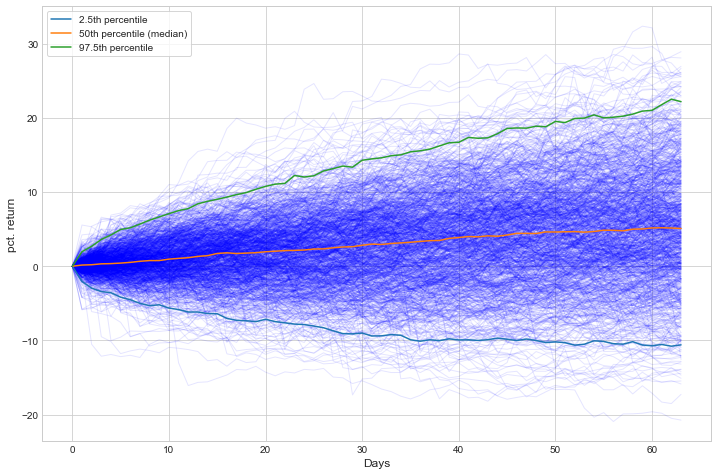

----------------------------------------------------------------------------------------------------

Simulates the efficient tangent portfolio 1000 times over 63 days


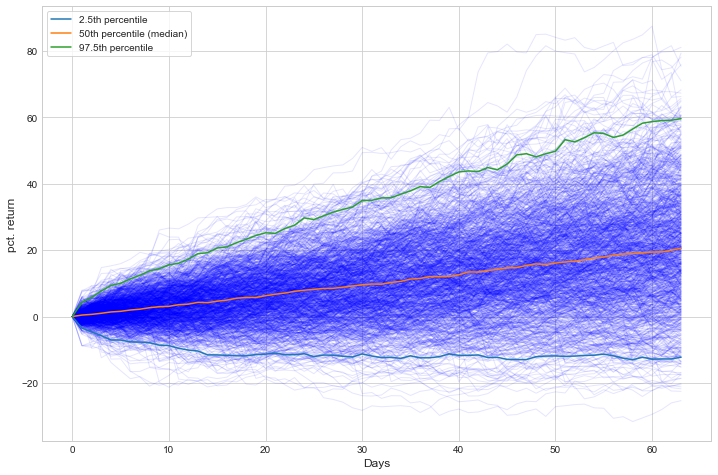

----------------------------------------------------------------------------------------------------
Simulates the optimal calmar ratio portfolio (shorting is not allowed) 1000 times over 63 days


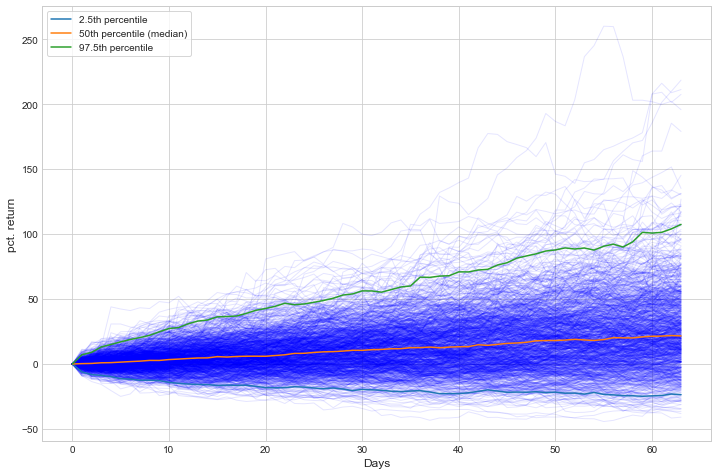

In [10]:
pftools.simulated_portfolios(smvw, stw, scw, rdf, N = 1000, t = 63, shorting = True)

Simulating 1000 timeseries for each type of portfolio where shorting is NOT allowed
--------------------------------------------------------------------------------

Simulates the minimum variance portfolio 1000 times over 63 days


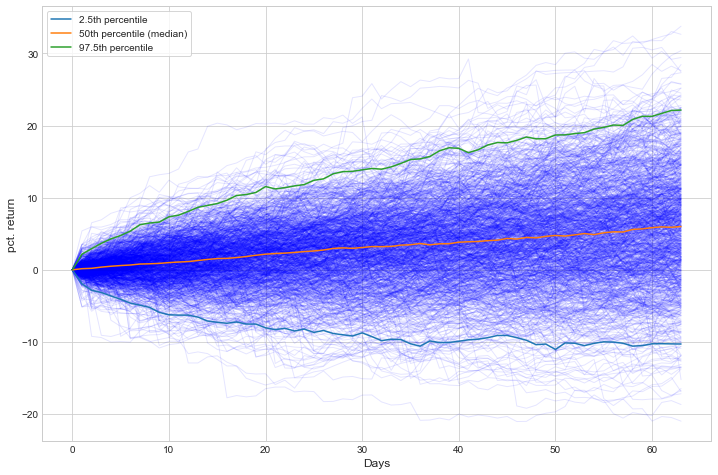

----------------------------------------------------------------------------------------------------

Simulates the efficient tangent portfolio 1000 times over 63 days


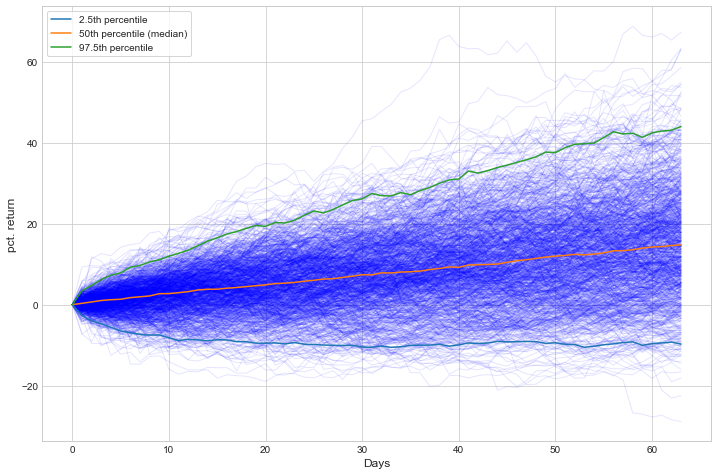

----------------------------------------------------------------------------------------------------
Simulates the optimal calmar ratio portfolio (shorting is not allowed) 1000 times over 63 days


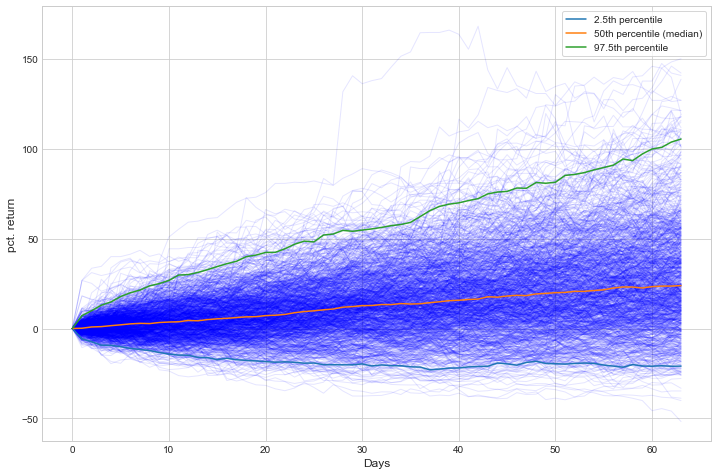

In [11]:
pftools.simulated_portfolios(mvw, tw, cw, rdf, N = 1000, t = 63)

In [12]:
mvw = np.array(mvw).reshape(-1)
rdfclean = rdf.dropna()

In [13]:
matrixrdf = np.array(rdfclean)
matrdf = matrixrdf[np.random.choice(matrixrdf.shape[0], (2,10), replace = False)]
matrdf = matrdf/100+1
# print(matrdf)
matcdf = np.cumprod(matrdf, axis = 1)
# print('next')
print(matcdf.T.shape)
matmvw = np.tile(mvw,(2,10,1))
print(matmvw)
print(matmvw.T.shape)
# simulations = np.zeros((2,10,matrixrdf.shape[1]))
# print(matcdf)
print((matmvw*matcdf).shape)
# simulations = matmvw@matcdf-100
# print(matcdf.T.shape)
# simulations = np.tensordot(matcdf
# simulations = np.inner(matmvw,matcdf)
# simulations.shape
# np.array(weights@rdfcleani.T)-100
# simulations[i,1:] = np.array(weights@rdfcleani.T)-100

(16, 10, 2)
[[[17.7  38.49  0.    5.66  4.21  0.   16.51  0.    4.43  2.09  0.
    0.44  3.31  1.37  0.    5.76]
  [17.7  38.49  0.    5.66  4.21  0.   16.51  0.    4.43  2.09  0.
    0.44  3.31  1.37  0.    5.76]
  [17.7  38.49  0.    5.66  4.21  0.   16.51  0.    4.43  2.09  0.
    0.44  3.31  1.37  0.    5.76]
  [17.7  38.49  0.    5.66  4.21  0.   16.51  0.    4.43  2.09  0.
    0.44  3.31  1.37  0.    5.76]
  [17.7  38.49  0.    5.66  4.21  0.   16.51  0.    4.43  2.09  0.
    0.44  3.31  1.37  0.    5.76]
  [17.7  38.49  0.    5.66  4.21  0.   16.51  0.    4.43  2.09  0.
    0.44  3.31  1.37  0.    5.76]
  [17.7  38.49  0.    5.66  4.21  0.   16.51  0.    4.43  2.09  0.
    0.44  3.31  1.37  0.    5.76]
  [17.7  38.49  0.    5.66  4.21  0.   16.51  0.    4.43  2.09  0.
    0.44  3.31  1.37  0.    5.76]
  [17.7  38.49  0.    5.66  4.21  0.   16.51  0.    4.43  2.09  0.
    0.44  3.31  1.37  0.    5.76]
  [17.7  38.49  0.    5.66  4.21  0.   16.51  0.    4.43  2.09  0.
    0.44  3.

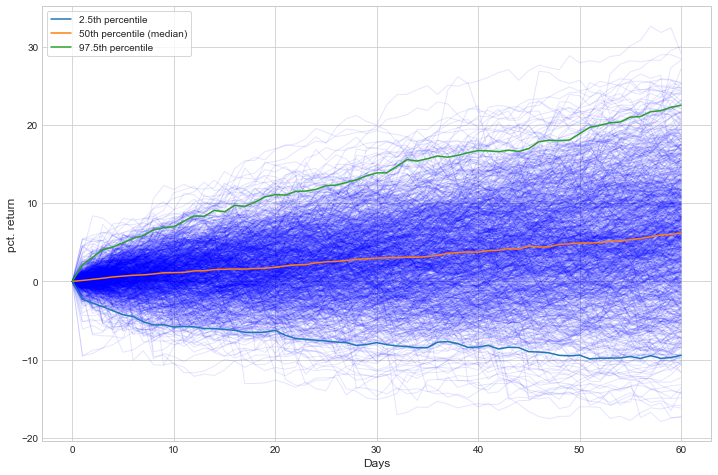

In [23]:

_ = sim_pf(rdfclean,mvw)

In [19]:
def sim_pf(rdf, weights, N = 1000, t = 60):
    # i. preparing storage of simulations
    simulations = np.zeros((N,t+1))
    
    # ii. drawing t random days N times 
    for i in range(N):
        # a. sampling data and calculating the cumulative return
        rdfcleani = rdf.sample(t)
        rdfcleani = rdfcleani/100+1
        rdfcleani = rdfcleani.cumprod()
        
        # b. calculating portfolio cumulated return for the 60 days as an array
        simulations[i,1:] = np.array(weights@rdfcleani.T)-100
    
    # iii. converging simulations to dataframe
    dfsimulations = pd.DataFrame(simulations).T
    
    # iv. plotting simulated return paths
    fig = plt.figure(figsize = (12,8))
    plt.plot(dfsimulations, linewidth = 1, alpha = .1, color = 'blue')
    plt.plot(dfsimulations.quantile([.025,.5,.975], axis = 1).T, label = ['2.5th percentile', '50th percentile (median)','97.5th percentile'])
    plt.legend(frameon = True)
    plt.xlabel('Days', fontsize = 12)
    plt.ylabel('pct. return',fontsize = 12)
    plt.show();
    
    return dfsimulations

In [19]:
from scipy import optimize
def optimize_pf(pftype,sigma,mu,df,N,shorting = False):
    # i. establishing names, number of assets and initiating storage
    names = df.columns
    M = len(names)
    fopt = np.inf # initialize optimal value
    wopt = np.nan # initialize optimal weights
    ws = [] # storing all optimal weights in list
    fs = [] # storing all optimal values of interest in list
    attempt = [] # storing the speficic no attempt
    
    # ii. creating bounds based on whether short-selling is allowed or not
    rng = np.random.default_rng(1995)
    if shorting == True:
        w0s = rng.uniform(-1+1e-8,1-1e-8,size = (N,M))
        bound = (-1+1e-8,1-1e-8)    
        # a. Calmar ration cannot be solved with shorting allowed??
        if pftype.lower() == 'calmar':
            print(f'Currently no numerical solution for maximum calmar ratio portfolio with shorting - will therefore be solved for\nSHORTING IS NOT ALLOWED')
            # bounds, weights cannot be negative, i.e. short-selling is not allowed
            w0s = rng.uniform(1e-8,1-1e-8,size = (N,M))
            bound = (1e-8,1-1e-8)
    else:
        # bounds, weights cannot be negative, i.e. short-selling is not allowed
        w0s = rng.uniform(1e-8,1-1e-8,size = (N,M))
        bound = (1e-8,1-1e-8)
    bounds = ((bound, ) * M)

    print(f'-'*55)
    
    # iii. objective functions
    if pftype.lower() == 'minvar':
        optimizing = 'variance'
        obj = lambda x: pftools.mvar(x,sigma)
        print(f'Will numerically solve the minimum variance portfolio')
    elif pftype.lower() == 'tangent':
        optimizing = 'Sharpe Ratio'
        obj = lambda x: -pftools.tangent(x,sigma,mu)
        print(f'Will numerically solve the efficient tangent portfolio')
    elif pftype.lower() == 'calmar':
        optimizing = 'Calmar Ratio'
        obj = lambda x: -pftools.calmar(x,df,mu)[1]
        print(f'Will numerically solve the calmar portfolio')
    else:
        print(f'Can only optimize portfolios: minimum variance (pftype = minvar), efficient tangent (pftype = tangent) and calmar ratio (pftype = calmar)')
    
    print(f'Multistart optimization')
    print(f'-'*55)
    
    # iv. multistart using SLSQP (bounded) minimizer
    for i, w0 in enumerate(w0s):
        # a. bounded optimization for given initial weights
        result = optimize.minimize(obj,w0,method = 'SLSQP',
                                  bounds=bounds)
        
        # b. storing solution (optimized value and its weights)
        f = result.fun

        # c. storing the optimal solution and eventual better optimal solutions
        if f < fopt:
            # 1. extracting weights from the optimal solution
            weights = result.x
            
            # 2. storing optimal value, its weights and corresponding return
            fopt = f
            wopt = weights/sum(weights)
            ropt = wopt @ mu
            
            # 3. making sure the sign is proper for the given portfolio
            if pftype.lower() == 'minvar':
                f = f
            else:
                f = -f
            
            # 4. storing all improved solutions for eventual print statement
            fs.append(f)
            ws.append(wopt)
            attempt.append(i)
            

    # v. summarize the performed optimizations
    print(f'Performed multistart optimization with {N} total attempts')
    print(f'The optimal solution improved {len(ws)} times')
    
    
    # vi. print statement depending on whether optimal solutions have changed noticably during multistart optimization
    wsols = np.around(np.array(ws),6)
    testsols = np.all(wsols == wsols[0], axis=1)
    if np.sum(testsols) < len(testsols):
        print(f'The improvements of the optimal solution resulted in a deviation of allocation of more than 1 pct. for at least 1 asset.')
        print(f'All optimal solution are as follows:')
        print(f'-'*20)
        for i,w in enumerate(wsols):
            print(f'Attempt {attempt[i]} had weights: {w*100} with {optimizing} = {f:.2f}')
    else:
        print(f'The improvements of the optimal solution resulted in no notable deviations of allocation.')
    print(f'-'*20)
    
    # vii. storing optimal portfolio weights and other stats
    if pftype.lower() == 'minvar':
        vopt = fopt
        sropt = ropt/np.sqrt(vopt)
        mdd, cropt = pftools.calmar(wopt,df,mu)
    elif pftype.lower() == 'tangent':
        vopt = wopt@sigma@wopt
        sropt = -fopt
        mdd, cropt = pftools.calmar(wopt,df,mu)
    else:
        vopt = wopt@sigma@wopt
        sropt = ropt/np.sqrt(vopt)
        mdd, cropt = pftools.calmar(wopt,df,mu)
    
    nwopt = np.around(wopt*100,2)
    wpfdf = pd.DataFrame({'Ticker':names, 'weight':nwopt})
    wpfdf = wpfdf.set_index('Ticker')
    statspfdf = pd.DataFrame.from_dict({'Annualized return':round(ropt,2),'Volatility':round(np.sqrt(vopt),2),
                                         'Sharpe ratio':round(sropt,2),'1m max drawdown':round(mdd,2),
                                        'Calmar ratio':round(cropt,2)},
                                       orient = 'index', columns = ['stats'])
    
    # viii. summarize the best optimal solution
    print(f'The optimal portfolio allocation ended up being:')
    display(wpfdf)
    print(f'With portfolio characteristics:')
    display(statspfdf)
    
    return wpfdf, statspfdf